In [ ]:
#| default_exp clip_plot

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports and setup

### Unconditional imports

In [ ]:
#| export

from __future__ import division
import warnings


In [ ]:
#|export
from clip_plot import utils
from fastcore.all import *

In [ ]:
#| export

warnings.filterwarnings("ignore")

In [ ]:
#| export

from os.path import join, exists, dirname, realpath
from shutil import rmtree
from distutils.dir_util import copy_tree
from pathlib import Path
import pkg_resources
import datetime
import argparse
from typing import Optional, List, Union, Tuple
import glob2
import uuid
import sys
import os

In [ ]:
#| export

def timestamp():
    """Return a string for printing the current time"""
    return str(datetime.datetime.now()) + ":"

### Image processing imports

Note that I have removed the "copy-web-only" conditional import path for now

`nbdev` does not like cells to have cells to have code and imports in the same cell:

https://nbdev.fast.ai/getting_started.html#q-what-is-the-warning-found-a-cell-containing-mix-of-imports-and-computations.-please-use-separate-cells

I think this may mean we don't get to do conditional imports. If we find a code path that really should have conditional imports, we can see if there is a workaround. For now, I don't feel "copy web only" is a very important functionality to keep.

In [ ]:
#| export

from sklearn.metrics import pairwise_distances_argmin_min
from collections import defaultdict, namedtuple
from dateutil.parser import parse as parse_date
from sklearn.preprocessing import minmax_scale
from pointgrid import align_points_to_grid
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from iiif_downloader import Manifest
from rasterfairy import coonswarp
from scipy.stats import kde
from PIL import ImageFile
import matplotlib.pyplot as plt
import multiprocessing
from tqdm.autonotebook import tqdm
import rasterfairy
import numpy as np
import itertools
import operator
import pickle
import random
import copy
import math
import gzip
import json
import csv

from hdbscan import HDBSCAN
from umap import UMAP, AlignedUMAP

from urllib.parse import unquote

# Keras imports
# from tensorflow.keras.preprocessing.image import save_img, img_to_array, array_to_img
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3, imagenet_utils # imagenet_utils not being used
# from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow import compat

### Optional install imports

In [ ]:
#| export

DEFAULTS = {
    "images": None,
    "meta_dir": None,
    "out_dir": "output",
    "max_images": None,
    "use_cache": True,
    "encoding": "utf8",
    "min_cluster_size": 20,
    "max_clusters": 10,
    "atlas_size": 2048,
    "cell_size": 32,
    "lod_cell_height": 128, # Why is not in parser?
    "n_neighbors": [15],
    "min_dist": [0.01],
    "n_components": 2,
    "metric": "correlation",
    "pointgrid_fill": 0.05,
    "gzip": False,
    "min_size": 100,
    "min_score": 0.3,
    "min_vertices": 18,
    "plot_id": str(uuid.uuid1()),
    "seed": 24,
    "n_clusters": 12,
    "geojson": None,
}

FILE_NAME = "filename"  # Filename name key

print(timestamp(), "Ignoring cuml-umap for now to avoid conditional import")
print("we may add cuml-umap option back later")
cuml_ready = False

cluster_method = "hdbscan"

# handle truncated images in PIL (managed by Pillow)
ImageFile.LOAD_TRUNCATED_IMAGES = True

"""
NB: Keras Image class objects return image.size as w,h
    Numpy array representations of images return image.shape as h,w,c
"""

2023-03-08 11:32:10.263886: Ignoring cuml-umap for now to avoid conditional import
we may add cuml-umap option back later


'\nNB: Keras Image class objects return image.size as w,h\n    Numpy array representations of images return image.shape as h,w,c\n'


## Entry

`process_images` will kick off all the main functions for the module

In [ ]:
#|export

def get_clip_plot_root() -> Path:
    # ipython doesn't have __file__ attribute
    if in_ipython():
        return Path(utils.__file__).parents[1]
    else:
        print(__file__)
        return Path(__file__).parents[1]

In [ ]:
#| export

copy_root_dir = get_clip_plot_root()

In [ ]:
#| export

def process_images(**kwargs):
    """Main method for processing user images and metadata"""
    kwargs = preprocess_kwargs(**kwargs)

    copy_web_assets(out_dir=kwargs['out_dir'])
    if kwargs["copy_web_only"]:
        print(timestamp(), "Done!")
        sys.exit()
    
    np.random.seed(kwargs["seed"])
    compat.v1.set_random_seed(kwargs["seed"])
    kwargs["out_dir"] = join(kwargs["out_dir"], "data")
    kwargs["image_paths"], kwargs["metadata"] = filter_images(**kwargs)
    write_metadata(**kwargs)
    
    kwargs["atlas_dir"] = get_atlas_data(**kwargs)
    kwargs["vecs"] = get_inception_vectors(**kwargs)
    get_manifest(**kwargs)
    write_images(**kwargs)
    print(timestamp(), "Done!")


def preprocess_kwargs(**kwargs):
    """Preprocess incoming key word arguments
    Converts n_neighbors and min_dist arguments into a list

    Args:
        n_neighbors (int, list[int], default = [15])
        min_dist (int, list[int], default = [0.01])

    Notes:
        Convenient hook for preprocessing arguments
    
    """
    for i in ["n_neighbors", "min_dist"]:
        if not isinstance(kwargs[i], list):
            kwargs[i] = [kwargs[i]]
    return kwargs

In [ ]:
#| export

def copy_web_assets(out_dir: str) -> None:
    """Copy the /web directory from the clipplot source to the users cwd.
    Copies version number into assets.
    
    Args: 
        out_dir (str): directory to copy web assets

    Returns:
        None
    """
    copy_root_dir = get_clip_plot_root()
    src = copy_root_dir / "clip_plot/web"

    # resolve will handle cases with ../ in the path
    dest = Path.cwd() / Path(out_dir).resolve()
    utils.copytree_agnostic(src.as_posix(), dest.as_posix())

    # write version numbers into output
    for i in ["index.html", os.path.join("assets", "js", "tsne.js")]:
        path = join(dest, i)
        with open(path, "r") as f:
            f = f.read().replace("VERSION_NUMBER", get_version())
            with open(path, "w") as out:
                out.write(f)


## Images

In [ ]:
#| export

def filter_images(**kwargs):
    """Main method for filtering images given user metadata (if provided)

    -Validate image:
        Loading (done by stream_images and Images)
        Size
        resizing
        oblong

    -Compare against metadata

    
    Args:
        atlas_size (int, default = 2048)
        cell_size (int, default = 32)
        lod_cell_height (int, default = 128)
        shuffle (Optional[bool], default = False) 

    Returns:
        images (list[str])
        metadata (list[dict])

    Notes:
        Assumes 'filename' is provided in metadata
        Convoluted compiling of metadata
        Should All Validation should belong to Image class?
        Need to split function
    """
    # validate that input image names are unique
    image_paths = get_image_paths(images=kwargs["images"], out_dir=kwargs["out_dir"])
    image_names = list(map(clean_filename,image_paths))
    duplicates = set([x for x in image_names if image_names.count(x) > 1])

    if duplicates:
        raise Exception(
            """Image filenames should be unique, but the following 
            filenames are duplicated\n{}""".format("\n".join(duplicates)))
    
    # optionally shuffle the image_paths
    if kwargs.get("shuffle", False):
        print(timestamp(), "Shuffling input images")
        random.Random(kwargs["seed"]).shuffle(image_paths)
    else:
        image_paths = sorted(image_paths)

    # optionally limit the number of images in image_paths
    if kwargs.get("max_images", False):
        image_paths = image_paths[: kwargs["max_images"]]        

    # process and filter the images
    filtered_image_paths = {}
    oblong_ratio = kwargs["atlas_size"] / kwargs["cell_size"]
    for img in Image.stream_images(image_paths=image_paths):
        valid, msg = img.valid(lod_cell_height=kwargs["lod_cell_height"], oblong_ratio=oblong_ratio) 
        if valid is True:
            filtered_image_paths[img.path] = img.filename
        else:
            print(timestamp(), msg)

    # if there are no remaining images, throw an error
    if len(filtered_image_paths) == 0:
        raise Exception("No images were found! Please check your input image glob.")

    # handle the case user provided no metadata
    if not kwargs.get("meta_dir", False):
        return [filtered_image_paths.keys(), []]

    # handle user metadata: retain only records with image and metadata
    metaList = get_metadata_list(meta_dir=kwargs['meta_dir'])
    metaDict = {clean_filename(i.get(FILE_NAME, "")): i for i in metaList}
    meta_bn = set(metaDict.keys())
    img_bn = set(filtered_image_paths.values())

    # identify images with metadata and those without metadata
    meta_present = img_bn.intersection(meta_bn)
    meta_missing = list(img_bn - meta_bn)

    # notify the user of images that are missing metadata
    if meta_missing:
        print(
            timestamp(),
            " ! Some images are missing metadata:\n  -",
            "\n  - ".join(meta_missing[:10]),
        )
        if len(meta_missing) > 10:
            print(timestamp(), " ...", len(meta_missing) - 10, "more")

        if os.path.exists(kwargs['out_dir']) is False:
            os.makedirs(kwargs['out_dir'])
            
        missing_dir = os.path.join(kwargs['out_dir'],"missing-metadata.txt")
        with open(missing_dir, "w") as out:
            out.write("\n".join(meta_missing))

    if not meta_present:
        raise Exception( f"""No image has matching metadata. Check if '{FILE_NAME}' key was provided in metadata files""")

    # get the sorted lists of images and metadata
    images = []
    metadata = []
    for path, fileName in filtered_image_paths.items():
        if fileName in meta_present:
            images.append(path)
            metadata.append(copy.deepcopy(metaDict[fileName]))

    return [images, metadata]

In [ ]:
#| export

def get_image_paths(images:str, out_dir: str) -> List[str]:
    """Called once to provide a list of image paths--handles IIIF manifest input.
    
    args:
        images (str): directory location of images.
        out_dir (str): output directory for downloaded IIIF files.

    returns:
        image_paths list(str): list of image paths.

    Note:
        Old/previous images are not deleted from IIIF directory.

    Todo:
        Consider separate function that handles IIIF images
        from glob images.
    """

    image_paths = None

    # Is images a iiif file or image directory?
    if os.path.isfile(images):
        # Handle list of IIIF image inputs
        iiif_dir = os.path.join(out_dir,"iiif-downloads")

        # Check if directory already contains anything
        if os.path.exists(iiif_dir) and os.listdir(iiif_dir):
            print("Warning: IIIF directory already contains content!")

        with open(images) as f:
            urls = [url.strip() for url in f.read().split("\n") if url.startswith("http")]
            count = 0
            for url in urls:
                try:
                    Manifest(url=url, out_dir=iiif_dir).save_images(limit=1)
                    count += 1
                except:
                    print(timestamp(), "Could not download url " + url)

            if count == 0:
                raise Exception('No IIIF images were successfully downloaded!')

            image_paths = glob2.glob(os.path.join(out_dir,"iiif-downloads", "images", "*"))
   
    # handle case where images flag points to a glob of images
    if not image_paths:
        image_paths = glob2.glob(images)

    # handle case user provided no images
    if not image_paths:
        raise FileNotFoundError("Error: No input images were found. Please check your --images glob")

    return image_paths


In [ ]:
#| export
def clean_filename(s, **kwargs):
    """Given a string that points to a filename, return a clean filename
    
    Args:
        s (str): filename path

    Returns:
        s (str): clean file name

    Notes:
        kwargs is not used at all
    
    """
    s = unquote(os.path.basename(s))
    invalid_chars = '<>:;,"/\\|?*[]'
    for i in invalid_chars:
        s = s.replace(i, "")
    return s

In [ ]:
#| export

##
# Metadata
##


def get_metadata_list(meta_dir: str) -> List[dict]:
    """Return a list of objects with image metadata.

    Will create 'tags' key if 'category' is in metadata
    but not 'tags'.
    
    Args:
        metadata (str, default = None): Metadata location

    Returns:
        l (List[dict]): List of metadata 

    Notes:
        No check for 'filename' is performed

    Todo:
        Think about separating .csv and json functionality.
        Can we use pandas numpy to process csv?
    """

    # handle csv metadata
    metaList = []
    if meta_dir.endswith(".csv"):
        with open(meta_dir) as f:
            reader = csv.reader(f)
            headers = [i.lower() for i in next(reader)]
            for i in reader:
                metaList.append(
                    {
                        headers[j]: i[j] if len(i) > j and i[j] else ""
                        for j, _ in enumerate(headers)
                    }
                )
    
    # handle json metadata
    else:
        for i in glob2.glob(meta_dir):
            with open(i) as f:
                metaList.append(json.load(f))

    # if the user provided a category but not a tag, use the category as the tag
    for metaDict in metaList:
        if "category" in metaDict and ("tags" in metaDict) is False:
            metaDict.update({"tags": metaDict["category"]})
    return metaList

In [ ]:
#| export

def write_metadata(metadata, **kwargs):
    """Write list `metadata` of objects to disk
    
    Args:
        metadata (list[dict])
        out_dir (str)

        subfunctions:
            write_json():
                gzip (Optional[bool]):
                encoding (Optional[str]): Required if gzip is provided
                    default = 'utf8'

    Returns:
        None

    Notes:
        Improve variable naming
    
    """
    if not metadata:
        return

    out_dir = join(kwargs["out_dir"], "metadata")
    for i in ["filters", "options", "file"]:
        out_path = join(out_dir, i)
        if not exists(out_path):
            os.makedirs(out_path)
    
    # create the lists of images with each tag
    d = defaultdict(list)
    for i in metadata:
        filename = clean_filename(i[FILE_NAME])
        i["tags"] = [j.strip() for j in i.get("tags", "").split("|")]
        for j in i["tags"]:
            d["__".join(j.split())].append(filename)
        write_json(os.path.join(out_dir, "file", filename + ".json"), i, **kwargs)

    write_json(
        os.path.join(out_dir, "filters", "filters.json"),
        [
            {
                "filter_name": "select",
                "filter_values": list(d.keys()),
            }
        ],
        **kwargs
    )

    # create the options for the category dropdown
    for i in d:
        write_json(os.path.join(out_dir, "options", i + ".json"), d[i], **kwargs)
    # create the map from date to images with that date (if dates present)
    date_d = defaultdict(list)
    for i in metadata:
        date = i.get("year", "")
        if date:
            date_d[date].append(clean_filename(i[FILE_NAME]))

    # find the min and max dates to show on the date slider
    dates = np.array([int(i.strip()) for i in date_d if is_number(i)])
    domain = {"min": float("inf"), "max": -float("inf")}
    mean = np.mean(dates)
    std = np.std(dates)
    for i in dates:
        # update the date domain with all non-outlier dates
        if abs(mean - i) < (std * 4):
            domain["min"] = int(min(i, domain["min"]))
            domain["max"] = int(max(i, domain["max"]))

    # write the dates json
    if len(date_d) > 1:
        write_json(
            os.path.join(out_dir, "dates.json"),
            {
                "domain": domain,
                "dates": date_d,
            },
            **kwargs
        )

In [ ]:
#| export

def is_number(s):
    """Return a boolean indicating if a string is a number
    
    Args:
        s (Any); Value to be checked

    Returns:
        bool
    
    """
    try:
        int(s)
        return True
    except:
        return False

In [ ]:
#| export

##
# Main
##


def get_manifest(**kwargs):
    """Create and return the base object for the manifest output file
    
    Args:
        atlas_dir (str)
        image_paths (str)
        plot_id (str, default = str(uuid.uuid1()))
        out_dir (str)
        metadata (list[dict]): Only checking if provided
        gzip (bool, default = False)
        atlas_size (int, default = 2048)
        cell_size (int, default = 32)
        lod_cell_height (int, default = 128)

        Need to check subfunctions


    Returns:
        None

    Notes:
        Original description is inadequate
        Function is to big (god function)
    
    """
    # load the atlas data
    atlas_data = json.load(open(join(kwargs["atlas_dir"], "atlas_positions.json")))
    # store each cell's size and atlas position
    atlas_ids = set([i["idx"] for i in atlas_data])
    sizes = [[] for _ in atlas_ids]
    pos = [[] for _ in atlas_ids]
    for idx, i in enumerate(atlas_data):
        sizes[i["idx"]].append([i["w"], i["h"]])
        pos[i["idx"]].append([i["x"], i["y"]])
    # obtain the paths to each layout's JSON positions
    layouts = get_layouts(**kwargs)
    # create a heightmap for the umap layout
    if "umap" in layouts and layouts["umap"]:
        get_heightmap(layouts["umap"]["variants"][0]["layout"], "umap", **kwargs)
    # specify point size scalars
    point_sizes = {}
    point_sizes["min"] = 0
    point_sizes["grid"] = 1 / math.ceil(len(kwargs["image_paths"]) ** (1 / 2))
    point_sizes["max"] = point_sizes["grid"] * 1.2
    point_sizes["scatter"] = point_sizes["grid"] * 0.2
    point_sizes["initial"] = point_sizes["scatter"]
    point_sizes["categorical"] = point_sizes["grid"] * 0.6
    point_sizes["geographic"] = point_sizes["grid"] * 0.025
    # fetch the date distribution data for point sizing
    if "date" in layouts and layouts["date"]:
        date_layout = read_json(layouts["date"]["labels"], **kwargs)
        point_sizes["date"] = 1 / (
            (date_layout["cols"] + 1) * len(date_layout["labels"])
        )
    # create manifest json
    manifest = {
        "version": get_version(),
        "plot_id": kwargs["plot_id"],
        "output_directory": os.path.split(kwargs["out_dir"])[0],
        "layouts": layouts,
        "initial_layout": "umap",
        "point_sizes": point_sizes,
        "imagelist": get_path("imagelists", "imagelist", **kwargs),
        "atlas_dir": kwargs["atlas_dir"],
        "metadata": True if kwargs["metadata"] else False,
        "default_hotspots": get_hotspots(layouts=layouts, **kwargs),
        "custom_hotspots": get_path(
            "hotspots", "user_hotspots", add_hash=False, **kwargs
        ),
        "gzipped": kwargs["gzip"],
        "config": {
            "sizes": {
                "atlas": kwargs["atlas_size"],
                "cell": kwargs["cell_size"],
                "lod": kwargs["lod_cell_height"],
            },
        },
        "creation_date": datetime.datetime.today().strftime("%d-%B-%Y-%H:%M:%S"),
    }
    # write the manifest without gzipping
    no_gzip_kwargs = {
        "out_dir": kwargs["out_dir"],
        "gzip": False,
        "plot_id": kwargs["plot_id"],
    }
    path = get_path("manifests", "manifest", **no_gzip_kwargs)
    write_json(path, manifest, **no_gzip_kwargs)
    path = get_path(None, "manifest", add_hash=False, **no_gzip_kwargs)
    write_json(path, manifest, **no_gzip_kwargs)
    # create images json
    imagelist = {
        "cell_sizes": sizes,
        "images": [clean_filename(i) for i in kwargs["image_paths"]],
        "atlas": {
            "count": len(atlas_ids),
            "positions": pos,
        },
    }
    write_json(manifest["imagelist"], imagelist, **kwargs)

In [ ]:
#| export

##
# Atlases
##


def get_atlas_data(**kwargs):
    """
    Generate and save to disk all atlases to be used for this visualization
    If square, center each cell in an nxn square, else use uniform height

    Args:
        out_dir (str)
        plot_id (str, default = str(uuid.uuid1()))
        use_cache (bool, default = False)
        shuffle (Optional[bool], default = False)
        atlas_size (int, default = 2048)
        cell_size (int, default = 32)
        lod_cell_height (int, default = 128)


    Returns:
        out_dir (str): Atlas location 

    Notes:

    """
    # if the atlas files already exist, load from cache
    out_dir = os.path.join(kwargs["out_dir"], "atlases", kwargs["plot_id"])
    if (
        os.path.exists(out_dir)
        and kwargs["use_cache"]
        and not kwargs.get("shuffle", False)
    ):
        print(timestamp(), "Loading saved atlas data")
        return out_dir
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    # else create the atlas images and store the positions of cells in atlases
    print(timestamp(), "Creating atlas files")
    n = 0  # number of atlases
    x = 0  # x pos in atlas
    y = 0  # y pos in atlas
    positions = []  # l[cell_idx] = atlas data
    atlas = np.zeros((kwargs["atlas_size"], kwargs["atlas_size"], 3))
    for idx, i in enumerate(Image.stream_images(image_paths=kwargs["image_paths"], metadata=kwargs["metadata"])):
        cell_data = i.resize_to_height(kwargs["cell_size"])
        _, v, _ = cell_data.shape
        appendable = False
        if (x + v) <= kwargs["atlas_size"]:
            appendable = True
        elif (y + (2 * kwargs["cell_size"])) <= kwargs["atlas_size"]:
            y += kwargs["cell_size"]
            x = 0
            appendable = True
        if not appendable:
            save_atlas(atlas, out_dir, n)
            n += 1
            atlas = np.zeros((kwargs["atlas_size"], kwargs["atlas_size"], 3))
            x = 0
            y = 0
        atlas[y : y + kwargs["cell_size"], x : x + v] = cell_data
        # find the size of the cell in the lod canvas
        lod_data = i.resize_to_max(kwargs["lod_cell_height"])
        h, w, _ = lod_data.shape  # h,w,colors in lod-cell sized image `i`
        positions.append(
            {
                "idx": n,  # atlas idx
                "x": x,  # x offset of cell in atlas
                "y": y,  # y offset of cell in atlas
                "w": w,  # w of cell at lod size
                "h": h,  # h of cell at lod size
            }
        )
        x += v
    save_atlas(atlas, out_dir, n)
    out_path = os.path.join(out_dir, "atlas_positions.json")
    with open(out_path, "w") as out:
        json.dump(positions, out)
    return out_dir


def save_atlas(atlas, out_dir, n):
    """Save an atlas to disk"""
    out_path = join(out_dir, "atlas-{}.jpg".format(n))
    save_image(out_path, atlas)

In [ ]:
#| export

##
# Layouts
##


def get_layouts(**kwargs):
    """Get the image positions in each projection"""
    umap = get_umap_layout(**kwargs)
    layouts = {
        "umap": umap,
        "alphabetic": {
            "layout": get_alphabetic_layout(**kwargs),
        },
        "grid": {
            "layout": get_rasterfairy_layout(umap=umap, **kwargs),
        },
        "categorical": get_categorical_layout(**kwargs),
        "date": get_date_layout(**kwargs),
        "geographic": get_geographic_layout(**kwargs),
        "custom": get_custom_layout(**kwargs),
    }
    return layouts

In [ ]:
#| export

def get_inception_vectors(**kwargs):
    """Create and return Inception vector representation of Image() instances"""
    print(
        timestamp(),
        "Creating Inception vectors for {} images".format(len(kwargs["image_paths"])),
    )
    vector_dir = os.path.join(kwargs["out_dir"], "image-vectors", "inception")
    if not os.path.exists(vector_dir):
        os.makedirs(vector_dir)
    base = InceptionV3(
        include_top=True,
        weights="imagenet",
    )
    model = Model(inputs=base.input, outputs=base.get_layer("avg_pool").output)
    print(timestamp(), "Creating image array")
    vecs = []
    with tqdm(total=len(kwargs["image_paths"])) as progress_bar:
        for idx, i in enumerate(Image.stream_images(image_paths=kwargs["image_paths"], metadata=kwargs["metadata"])):
            vector_path = os.path.join(vector_dir, clean_filename(i.path) + ".npy")
            if os.path.exists(vector_path) and kwargs["use_cache"]:
                vec = np.load(vector_path)
            else:
                im = preprocess_input(image_to_array(i.original.resize((299, 299))))
                vec = model.predict(np.expand_dims(im, 0)).squeeze()
                np.save(vector_path, vec)
            vecs.append(vec)
            progress_bar.update(1)
    return np.array(vecs)

In [ ]:
#| export

def get_umap_layout(**kwargs):
    """Get the x,y positions of images passed through a umap projection"""
    vecs = kwargs["vecs"]
    w = PCA(n_components=min(100, len(vecs))).fit_transform(vecs)
    # single model umap
    if len(kwargs["n_neighbors"]) == 1 and len(kwargs["min_dist"]) == 1:
        return process_single_layout_umap(w, **kwargs)
    else:
        return process_multi_layout_umap(w, **kwargs)


def process_single_layout_umap(v, **kwargs):
    """Create a single layout UMAP projection"""
    print(timestamp(), "Creating single umap layout")
    model = get_umap_model(**kwargs)
    out_path = get_path("layouts", "umap", **kwargs)
    if cuml_ready:
        z = model.fit(v).embedding_
    else:
        if os.path.exists(out_path) and kwargs["use_cache"]:
            return out_path
        y = []
        if kwargs.get("metadata", False):
            labels = [i.get("label", None) for i in kwargs["metadata"]]
            # if the user provided labels, integerize them
            if any([i for i in labels]):
                d = defaultdict(lambda: len(d))
                for i in labels:
                    if i == None:
                        y.append(-1)
                    else:
                        y.append(d[i])
                y = np.array(y)
        # project the PCA space down to 2d for visualization
        z = model.fit(v, y=y if np.any(y) else None).embedding_
    return {
        "variants": [
            {
                "n_neighbors": kwargs["n_neighbors"][0],
                "min_dist": kwargs["min_dist"][0],
                "layout": write_layout(out_path, z, **kwargs),
                "jittered": get_pointgrid_layout(out_path, "umap", **kwargs),
            }
        ]
    }


def process_multi_layout_umap(v, **kwargs):
    """Create a multi-layout UMAP projection"""
    print(timestamp(), "Creating multi-umap layout")
    params = []
    for n_neighbors, min_dist in itertools.product(
        kwargs["n_neighbors"], kwargs["min_dist"]
    ):
        filename = "umap-n_neighbors_{}-min_dist_{}".format(n_neighbors, min_dist)
        out_path = get_path("layouts", filename, **kwargs)
        params.append(
            {
                "n_neighbors": n_neighbors,
                "min_dist": min_dist,
                FILE_NAME: filename,
                "out_path": out_path,
            }
        )
    # map each image's index to itself and create one copy of that map for each layout
    relations_dict = {idx: idx for idx, _ in enumerate(v)}
    # determine the subset of params that have already been computed
    uncomputed_params = [i for i in params if not os.path.exists(i["out_path"])]
    # determine the filepath where this model will be saved
    model_filename = "umap-" + str(abs(hash(kwargs["images"])))
    model_path = get_path("models", model_filename, **kwargs).replace(".json", ".gz")
    out_dir = os.path.join(kwargs["out_dir"], "models")
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    # load or create the model
    if os.path.exists(model_path):
        model = load_model(model_path)
        for i in uncomputed_params:
            model.update(v, relations_dict.copy())
        # after updating, we can read the results from the end of the updated model
        for idx, i in enumerate(uncomputed_params):
            embedding = z.embeddings_[len(uncomputed_params) - idx]
            write_layout(i["out_path"], embedding, **kwargs)
    else:
        model = AlignedUMAP(
            n_neighbors=[i["n_neighbors"] for i in uncomputed_params],
            min_dist=[i["min_dist"] for i in uncomputed_params],
        )
        # fit the model on the data
        z = model.fit(
            [v for _ in params], relations=[relations_dict for _ in params[1:]]
        )
        for idx, i in enumerate(params):
            write_layout(i["out_path"], z.embeddings_[idx], **kwargs)
        # save the model
        save_model(model, model_path)
    # load the list of layout variants
    l = []
    for i in params:
        l.append(
            {
                "n_neighbors": i["n_neighbors"],
                "min_dist": i["min_dist"],
                "layout": i["out_path"],
                "jittered": get_pointgrid_layout(
                    i["out_path"], i[FILE_NAME], **kwargs
                ),
            }
        )
    return {
        "variants": l,
    }


def save_model(model, path):
    try:
        params = model.get_params()
        attributes_names = [
            attr for attr in model.__dir__() if attr not in params and attr[0] != "_"
        ]
        attributes = {key: model.__getattribute__(key) for key in attributes_names}
        attributes["embeddings_"] = list(model.embeddings_)
        for x in ["fit", "fit_transform", "update", "get_params", "set_params"]:
            del attributes[x]
        all_params = {
            "umap_params": params,
            "umap_attributes": {key: value for key, value in attributes.items()},
        }
        pickle.dump(all_params, open(path, "wb"))
    except:
        print(timestamp(), "Could not save model")


def load_model(path):
    params = pickle.load(open(path, "rb"))
    model = AlignedUMAP()
    model.set_params(**params.get("umap_params"))
    for attr, value in params.get("umap_attributes").items():
        model.__setattr__(attr, value)
    model.__setattr__(
        "embeddings_", List(params.get("umap_attributes").get("embeddings_"))
    )


def get_umap_model(**kwargs):
    if cuml_ready:
        return UMAP(
            n_neighbors=kwargs["n_neighbors"][0],
            min_dist=kwargs["min_dist"][0],
            n_components=kwargs["n_components"],
            random_state=kwargs["seed"],
            verbose=5,
        )
    else:
        return UMAP(
            n_neighbors=kwargs["n_neighbors"][0],
            min_dist=kwargs["min_dist"][0],
            n_components=kwargs["n_components"],
            metric=kwargs["metric"],
            random_state=kwargs["seed"],
            transform_seed=kwargs["seed"],
        )

In [ ]:
#| export

def get_rasterfairy_layout(**kwargs):
    """Get the x, y position of images passed through a rasterfairy projection"""
    print(timestamp(), "Creating rasterfairy layout")
    out_path = get_path("layouts", "rasterfairy", **kwargs)
    if os.path.exists(out_path) and kwargs["use_cache"]:
        return out_path
    umap = np.array(read_json(kwargs["umap"]["variants"][0]["layout"], **kwargs))
    if umap.shape[-1] != 2:
        print(timestamp(), "Could not create rasterfairy layout because data is not 2D")
        return None
    umap = (umap + 1) / 2  # scale 0:1
    try:
        umap = coonswarp.rectifyCloud(
            umap,  # stretch the distribution
            perimeterSubdivisionSteps=4,
            autoPerimeterOffset=False,
            paddingScale=1.05,
        )
    except Exception as exc:
        print(timestamp(), "Coonswarp rectification could not be performed", exc)
    pos = rasterfairy.transformPointCloud2D(umap)[0]
    return write_layout(out_path, pos, **kwargs)


def get_alphabetic_layout(**kwargs):
    """Get the x,y positions of images in a grid projection"""
    print(timestamp(), "Creating grid layout")
    out_path = get_path("layouts", "grid", **kwargs)
    if os.path.exists(out_path) and kwargs["use_cache"]:
        return out_path
    paths = kwargs["image_paths"]
    n = math.ceil(len(paths) ** (1 / 2))
    l = []  # positions
    for i, _ in enumerate(paths):
        x = i % n
        y = math.floor(i / n)
        l.append([x, y])
    z = np.array(l)
    return write_layout(out_path, z, **kwargs)


def get_pointgrid_layout(path, label, **kwargs):
    """Gridify the positions in `path` and return the path to this new layout"""
    print(timestamp(), "Creating {} pointgrid".format(label))
    out_path = get_path("layouts", label + "-jittered", **kwargs)
    if os.path.exists(out_path) and kwargs["use_cache"]:
        return out_path
    arr = np.array(read_json(path, **kwargs))
    if arr.shape[-1] != 2:
        print(timestamp(), "Could not create pointgrid layout because data is not 2D")
        return None
    z = align_points_to_grid(arr, fill=0.01)
    return write_layout(out_path, z, **kwargs)


def get_custom_layout(**kwargs):
    out_path = get_path("layouts", "custom", **kwargs)
    if os.path.exists(out_path) and kwargs["use_cache"]:
        return out_path
    if not kwargs.get("metadata"):
        return
    found_coords = False
    coords = []
    for i in Image.stream_images(image_paths=kwargs["image_paths"], metadata=kwargs["metadata"]):
        x = i.metadata.get("x")
        y = i.metadata.get("y")
        if x and y:
            found_coords = True
            coords.append([x, y])
        else:
            if found_coords:
                print(
                    timestamp(),
                    "Some images are missing coordinates; skipping custom layout",
                )
    if not found_coords:
        return
    coords = np.array(coords).astype(np.float)
    coords = (minmax_scale(coords) - 0.5) * 2
    print(timestamp(), "Creating custom layout")
    return {
        "layout": write_layout(
            out_path, coords.tolist(), scale=False, round=False, **kwargs
        ),
    }

### Date Layout

In [ ]:
#| export

def get_date_layout(cols=3, bin_units="years", **kwargs):
    """
    Get the x,y positions of input images based on their dates
    @param int cols: the number of columns to plot for each bar
    @param str bin_units: the temporal units to use when creating bins
    """
    date_vals = [
        kwargs["metadata"][i].get("year", False) for i in range(len(kwargs["metadata"]))
    ]
    if not kwargs["metadata"] or not any(date_vals):
        return False
    # if the data layouts have been cached, return them
    positions_out_path = get_path("layouts", "timeline", **kwargs)
    labels_out_path = get_path("layouts", "timeline-labels", **kwargs)
    if (
        os.path.exists(positions_out_path)
        and os.path.exists(labels_out_path)
        and kwargs["use_cache"]
    ):
        return {
            "layout": positions_out_path,
            "labels": labels_out_path,
        }
    # date layout is not cached, so fetch dates and process
    print(timestamp(), "Creating date layout with {} columns".format(cols))
    datestrings = [i.metadata.get("year", "no_date") for i in Image.stream_images(image_paths=kwargs["image_paths"], metadata=kwargs["metadata"])]
    dates = [datestring_to_date(i) for i in datestrings]
    rounded_dates = [round_date(i, bin_units) for i in dates]
    # create d[formatted_date] = [indices into datestrings of dates that round to formatted_date]
    d = defaultdict(list)
    for idx, i in enumerate(rounded_dates):
        d[i].append(idx)
    # determine the number of distinct grid positions in the x and y axes
    n_coords_x = (cols + 1) * len(d)
    n_coords_y = 1 + max([len(d[i]) for i in d]) // cols
    if n_coords_y > n_coords_x:
        return get_date_layout(cols=int(cols * 2), **kwargs)
    # create a mesh of grid positions in clip space -1:1 given the time distribution
    grid_x = (np.arange(0, n_coords_x) / (n_coords_x - 1)) * 2
    grid_y = (np.arange(0, n_coords_y) / (n_coords_x - 1)) * 2
    # divide each grid axis by half its max length to center at the origin 0,0
    grid_x = grid_x - np.max(grid_x) / 2.0
    grid_y = grid_y - np.max(grid_y) / 2.0
    # make dates increase from left to right by sorting keys of d
    d_keys = np.array(list(d.keys()))
    seconds = np.array([date_to_seconds(dates[d[i][0]]) for i in d_keys])
    d_keys = d_keys[np.argsort(seconds)]
    # determine which images will fill which units of the grid established above
    coords = np.zeros(
        (len(datestrings), 2)
    )  # 2D array with x, y clip-space coords of each date
    for jdx, j in enumerate(d_keys):
        for kdx, k in enumerate(d[j]):
            x = jdx * (cols + 1) + (kdx % cols)
            y = kdx // cols
            coords[k] = [grid_x[x], grid_y[y]]
    # find the positions of labels
    label_positions = np.array(
        [[grid_x[i * (cols + 1)], grid_y[0]] for i in range(len(d))]
    )
    # move the labels down in the y dimension by a grid unit
    dx = grid_x[1] - grid_x[0]  # size of a single cell
    label_positions[:, 1] = label_positions[:, 1] - dx
    # quantize the label positions and label positions
    image_positions = round_floats(coords)
    label_positions = round_floats(label_positions.tolist())
    # write and return the paths to the date based layout
    return {
        "layout": write_json(positions_out_path, image_positions, **kwargs),
        "labels": write_json(
            labels_out_path,
            {
                "positions": label_positions,
                "labels": d_keys.tolist(),
                "cols": cols,
            },
            **kwargs
        ),
    }


def datestring_to_date(datestring):
    """
    Given a string representing a date return a datetime object
    """
    try:
        return parse_date(
            str(datestring), fuzzy=True, default=datetime.datetime(9999, 1, 1)
        )
    except Exception as exc:
        print(timestamp(), "Could not parse datestring {}".format(datestring))
        return datestring


def date_to_seconds(date):
    """
    Given a datetime object return an integer representation for that datetime
    """
    if isinstance(date, datetime.datetime):
        return (date - datetime.datetime.today()).total_seconds()
    else:
        return -float("inf")


def round_date(date, unit):
    """
    Return `date` truncated to the temporal unit specified in `units`
    """
    if not isinstance(date, datetime.datetime):
        return "no_date"
    formatted = date.strftime("%d %B %Y -- %X")
    if unit in set(["seconds", "minutes", "hours"]):
        date = formatted.split("--")[1].strip()
        if unit == "seconds":
            date = date
        elif unit == "minutes":
            date = ":".join(d.split(":")[:-1]) + ":00"
        elif unit == "hours":
            date = date.split(":")[0] + ":00:00"
    elif unit in set(["days", "months", "years", "decades", "centuries"]):
        date = formatted.split("--")[0].strip()
        if unit == "days":
            date = date
        elif unit == "months":
            date = " ".join(date.split()[1:])
        elif unit == "years":
            date = date.split()[-1]
        elif unit == "decades":
            date = str(int(date.split()[-1]) // 10) + "0"
        elif unit == "centuries":
            date = str(int(date.split()[-1]) // 100) + "00"
    return date

### Metadata Layout

In [ ]:
#| export

def get_categorical_layout(null_category="Other", margin=2, **kwargs):
    """
    Return a numpy array with shape (n_points, 2) with the point
    positions of observations in box regions determined by
    each point's category metadata attribute (if applicable)
    """
    if not kwargs.get("metadata", False):
        return False
    # determine the out path and return from cache if possible
    out_path = get_path("layouts", "categorical", **kwargs)
    labels_out_path = get_path("layouts", "categorical-labels", **kwargs)
    # accumulate d[category] = [indices of points with category]
    categories = [i.get("category", None) for i in kwargs["metadata"]]
    if not any(categories) or len(set(categories) - set([None])) == 1:
        return False
    d = defaultdict(list)
    for idx, i in enumerate(categories):
        d[i].append(idx)
    # store the number of observations in each group
    keys_and_counts = [{"key": i, "count": len(d[i])} for i in d]
    keys_and_counts.sort(key=operator.itemgetter("count"), reverse=True)
    # get the box layout then subdivide into discrete points
    boxes = get_categorical_boxes([i["count"] for i in keys_and_counts], margin=margin)
    points = get_categorical_points(boxes)
    # sort the points into the order of the observations in the metadata
    counts = {i["key"]: 0 for i in keys_and_counts}
    offsets = {i["key"]: 0 for i in keys_and_counts}
    for idx, i in enumerate(keys_and_counts):
        offsets[i["key"]] += sum([j["count"] for j in keys_and_counts[:idx]])
    sorted_points = []
    for idx, i in enumerate(Image.stream_images(image_paths=kwargs["image_paths"], metadata=kwargs["metadata"])):
        category = i.metadata.get("category", null_category)
        sorted_points.append(points[offsets[category] + counts[category]])
        counts[category] += 1
    sorted_points = np.array(sorted_points)
    # add to the sorted points the anchors for the text labels for each group
    text_anchors = np.array([[i.x, i.y - margin / 2] for i in boxes])
    # add the anchors to the points - these will be removed after the points are projected
    sorted_points = np.vstack([sorted_points, text_anchors])
    # scale -1:1 using the largest axis as the scaling metric
    _max = np.max(sorted_points)
    for i in range(2):
        _min = np.min(sorted_points[:, i])
        sorted_points[:, i] -= _min
        sorted_points[:, i] /= _max - _min
        sorted_points[:, i] -= np.max(sorted_points[:, i]) / 2
        sorted_points[:, i] *= 2
    # separate out the sorted points and text positions
    text_anchors = sorted_points[-len(text_anchors) :]
    sorted_points = sorted_points[: -len(text_anchors)]
    z = round_floats(sorted_points.tolist())
    return {
        "layout": write_json(out_path, z, **kwargs),
        "labels": write_json(
            labels_out_path,
            {
                "positions": round_floats(text_anchors.tolist()),
                "labels": [i["key"] for i in keys_and_counts],
            },
            **kwargs
        ),
    }


def get_categorical_boxes(group_counts, margin=2):
    """
    @arg [int] group_counts: counts of the number of images in each
      distinct level within the metadata's caetgories
    @kwarg int margin: space between boxes in the 2D layout
    @returns [Box] an array of Box() objects; one per level in `group_counts`
    """
    group_counts = sorted(group_counts, reverse=True)
    boxes = []
    for i in group_counts:
        w = h = math.ceil(i ** (1 / 2))
        boxes.append(Box(i, w, h, None, None))
    # find the position along x axis where we want to create a break
    wrap = math.floor(sum([i.cells for i in boxes]) ** (1 / 2)) - (2 * margin)
    # find the valid positions on the y axis
    y = margin
    y_spots = []
    for i in boxes:
        if (y + i.h + margin) <= wrap:
            y_spots.append(y)
            y += i.h + margin
        else:
            y_spots.append(y)
            break
    # get a list of lists where sublists contain elements at the same y position
    y_spot_index = 0
    for i in boxes:
        # find the y position
        y = y_spots[y_spot_index]
        # find members with this y position
        row_members = [j.x + j.w for j in boxes if j.y == y]
        # assign the y position
        i.y = y
        y_spot_index = (y_spot_index + 1) % len(y_spots)
        # assign the x position
        i.x = max(row_members) + margin if row_members else margin
    return boxes


def get_categorical_points(arr, unit_size=None):
    """Given an array of Box() objects, return a 2D distribution with shape (n_cells, 2)"""
    points_arr = []
    for i in arr:
        area = i.w * i.h
        per_unit = (area / i.cells) ** (1 / 2)
        x_units = math.ceil(i.w / per_unit)
        y_units = math.ceil(i.h / per_unit)
        if not unit_size:
            unit_size = min(i.w / x_units, i.h / y_units)
        for j in range(i.cells):
            x = j % x_units
            y = j // x_units
            points_arr.append(
                [
                    i.x + x * unit_size,
                    i.y + y * unit_size,
                ]
            )
    return np.array(points_arr)


class Box:
    """Store the width, height, and x, y coords of a box"""

    def __init__(self, *args):
        self.cells = args[0]
        self.w = args[1]
        self.h = args[2]
        self.x = None if len(args) < 4 else args[3]
        self.y = None if len(args) < 5 else args[4]

### Geographic Layout

In [ ]:
#| export

def get_geographic_layout(**kwargs):
    """Return a 2D array of image positions corresponding to lat, lng coordinates"""
    out_path = get_path("layouts", "geographic", **kwargs)
    l = []
    coords = False
    for idx, i in enumerate(Image.stream_images(image_paths=kwargs["image_paths"], metadata=kwargs["metadata"])):
        lat = float(i.metadata.get("lat", 0)) / 180
        lng = (
            float(i.metadata.get("lng", 0)) / 180
        )  # the plot draws longitude twice as tall as latitude
        if lat or lng:
            coords = True
        l.append([lng, lat])
    if coords:
        print(timestamp(), "Creating geographic layout")
        if kwargs["geojson"]:
            process_geojson(kwargs["geojson"])
        return {"layout": write_layout(out_path, l, scale=False, **kwargs)}
    elif kwargs["geojson"]:
        print(
            timestamp(),
            "GeoJSON is only processed if you also provide lat/lng coordinates for your images in a metadata file!",
        )
    return None


def process_geojson(geojson_path):
    """Given a GeoJSON filepath, write a minimal JSON output in lat lng coordinates"""
    with open(geojson_path, "r") as f:
        geojson = json.load(f)
    l = []
    for i in geojson:
        if isinstance(i, dict):
            for j in i.get("coordinates", []):
                for k in j:
                    l.append(k)
    with open(
        os.path.join("output", "assets", "json", "geographic-features.json"), "w"
    ) as out:
        json.dump(l, out)


### Helpers

In [ ]:
#| export

def get_path(*args, **kwargs):
    """Return the path to a JSON file with conditional gz extension"""
    sub_dir, filename = args
    out_dir = join(kwargs["out_dir"], sub_dir) if sub_dir else kwargs["out_dir"]
    if kwargs.get("add_hash", True):
        filename += "-" + kwargs["plot_id"]
    path = join(out_dir, filename + ".json")
    return path + ".gz" if kwargs.get("gzip", False) else path


def write_layout(path, obj, **kwargs):
    """Write layout json `obj` to disk and return the path to the saved file"""
    if kwargs.get("scale", True) != False:
        obj = (minmax_scale(obj) - 0.5) * 2  # scale -1:1
    if kwargs.get("round", True) != False:
        obj = round_floats(obj)
    if isinstance(obj, np.ndarray):
        obj = obj.tolist()
    return write_json(path, obj, **kwargs)


def round_floats(obj, digits=5):
    """Return 2D array obj with rounded float precision"""
    return [[round(float(j), digits) for j in i] for i in obj]


def write_json(path, obj, **kwargs):
    """Write json object `obj` to disk and return the path to that file"""
    out_dir, filename = os.path.split(path)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    if kwargs.get("gzip", False):
        with gzip.GzipFile(path, "w") as out:
            out.write(json.dumps(obj, indent=4).encode(kwargs["encoding"]))
        return path
    else:
        with open(path, "w") as out:
            json.dump(obj, out, indent=4)
        return path


def read_json(path, **kwargs):
    """Read and return the json object written by the current process at `path`"""
    if kwargs.get("gzip", False):
        with gzip.GzipFile(path, "r") as f:
            return json.loads(f.read().decode(kwargs["encoding"]))
    with open(path) as f:
        return json.load(f)


def get_hotspots(layouts={}, use_high_dimensional_vectors=True, **kwargs):
    """Return the stable clusters from the condensed tree of connected components from the density graph"""
    print(timestamp(), "Clustering data with {}".format(cluster_method))
    if use_high_dimensional_vectors:
        vecs = kwargs["vecs"]
    else:
        vecs = read_json(layouts["umap"]["variants"][0]["layout"], **kwargs)
    model = get_cluster_model(**kwargs)
    z = model.fit(vecs)
    # create a map from cluster label to image indices in cluster
    d = defaultdict(lambda: defaultdict(list))
    for idx, i in enumerate(z.labels_):
        if i != -1:
            d[i]["images"].append(idx)
            d[i]["img"] = clean_filename(kwargs["image_paths"][idx])
            d[i]["layout"] = "inception_vectors"
    # remove massive clusters
    deletable = []
    for i in d:
        # find percent of images in cluster
        image_percent = len(d[i]["images"]) / len(vecs)
        # determine if image or area percent is too large
        if image_percent > 0.5:
            deletable.append(i)
    for i in deletable:
        del d[i]
    # sort the clusers by size and then label the clusters
    clusters = d.values()
    clusters = sorted(clusters, key=lambda i: len(i["images"]), reverse=True)
    for idx, i in enumerate(clusters):
        i["label"] = "Cluster {}".format(idx + 1)
    # slice off the first `max_clusters`
    clusters = clusters[: kwargs["max_clusters"]]
    # save the hotspots to disk and return the path to the saved json
    print(timestamp(), "Found", len(clusters), "hotspots")
    return write_json(get_path("hotspots", "hotspot", **kwargs), clusters, **kwargs)


def get_cluster_model(**kwargs):
    """Return a model with .fit() method that can be used to cluster input vectors"""
    config = {
        "core_dist_n_jobs": multiprocessing.cpu_count(),
        "min_cluster_size": kwargs["min_cluster_size"],
        "cluster_selection_epsilon": 0.01,
        "min_samples": 1,
        "approx_min_span_tree": False,
    }
    return HDBSCAN(**config)


def get_heightmap(path, label, **kwargs):
    """Create a heightmap using the distribution of points stored at `path`"""

    X = read_json(path, **kwargs)
    if "positions" in X:
        X = X["positions"]
    X = np.array(X)
    if X.shape[-1] != 2:
        print(timestamp(), "Could not create heightmap because data is not 2D")
        return
    # create kernel density estimate of distribution X
    nbins = 200
    x, y = X.T
    xi, yi = np.mgrid[x.min() : x.max() : nbins * 1j, y.min() : y.max() : nbins * 1j]
    zi = kde.gaussian_kde(X.T)(np.vstack([xi.flatten(), yi.flatten()]))
    # create the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    fig.subplots_adjust(0, 0, 1, 1)
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading="gouraud", cmap=plt.cm.gray)
    plt.axis("off")
    # save the plot
    out_dir = os.path.join(kwargs["out_dir"], "heightmaps")
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    out_path = os.path.join(out_dir, label + "-heightmap.png")
    plt.savefig(out_path, pad_inches=0)


def write_images(**kwargs):
    """Write all originals and thumbs to the output dir"""
    for i in Image.stream_images(image_paths=kwargs["image_paths"], metadata=kwargs["metadata"]):
        filename = clean_filename(i.path)
        # copy original for lightbox
        out_dir = join(kwargs["out_dir"], "originals")
        if not exists(out_dir):
            os.makedirs(out_dir)
        out_path = join(out_dir, filename)
        if not os.path.exists(out_path):
            resized = i.resize_to_height(600)
            resized = array_to_image(resized)
            save_image(out_path, resized)
        # copy thumb for lod texture
        out_dir = join(kwargs["out_dir"], "thumbs")
        if not exists(out_dir):
            os.makedirs(out_dir)
        out_path = join(out_dir, filename)
        img = array_to_image(i.resize_to_max(kwargs["lod_cell_height"]))
        save_image(out_path, img)


In [ ]:
#| export

def get_version():
    """
    Return the version of clipplot installed
    Hardcoded for now
    """
    # return pkg_resources.get_distribution("clipplot").version
    return "0.0.1"

In [ ]:
#| export

class Image:
    def __init__(self, *args, **kwargs):
        self.path = args[0]
        self.filename = clean_filename(self.path)
        self.original = load_image(self.path) 
        self.metadata = kwargs["metadata"] if kwargs["metadata"] else {}

    def resize_to_max(self, n: int) -> np.array:
        """Resize self.original so its longest side has n pixels (maintain proportion).

        Args:
            n (int): maximum pixel length

        Returns:
            np.array: re-sized to n length
        """
        w, h = self.original.size
        if w > h:
            size = (n, int(n * h / w))
        else:
            size = (int(n * w / h), n)
    
        return image_to_array(self.original.resize(size))

    def resize_to_height(self, height: int) -> np.array:
        """Resize self.original into an image with height h and proportional width.

        Args:
            height (int): New height to resize to

        Returns:
            np.array: re-sized to height
        """
        w, h = self.original.size
        if (w / h * height) < 1:
            resizedwidth = 1
        else:
            resizedwidth = int(w / h * height)
        size = (resizedwidth, height)
        return image_to_array(self.original.resize(size))

    def resize_to_square(self, n: int, center: Optional[bool] = False) -> np.array:
        """Resize self.original to an image with nxn pixels (maintain proportion)
        if center, center the colored pixels in the square, else left align.

        Args:
            n (int)

        Notes:
            Function not being used
        """
        a = self.resize_to_max(n)
        h, w, c = a.shape
        pad_lr = int((n - w) / 2)  # left right pad
        pad_tb = int((n - h) / 2)  # top bottom pad
        b = np.zeros((n, n, 3))
        if center:
            b[pad_tb : pad_tb + h, pad_lr : pad_lr + w, :] = a
        else:
            b[:h, :w, :] = a
        return b

    def valid(self, lod_cell_height: int, oblong_ratio: Union[int,float]) -> tuple[bool, str]:
        """Validate that image can be opened and loaded correctly.

        Args:
            lod_cell_height (int):
            oblong_ratio (int|float): atlas_size/cell_size ratio

        Returns:
            Tuple[pass,msg]:
                pass (bool): True if passed validation
                msg (str): Reason why validation failed 
        """
        w, h = self.original.size
        # remove images with 0 height or width when resized to lod height
        if (h == 0) or (w == 0):
            return False, f"Skipping {self.path} because it contains 0 height or width"
        # remove images that have 0 height or width when resized
        try:
            resized = self.resize_to_max(lod_cell_height)
        except ValueError:
            return False, f"Skipping {self.path} because it contains 0 height or width when resized"
        except OSError:
            return False, f"Skipping {self.path} because it could not be resized"
        # remove images that are too wide for the atlas
        if (w / h) > (oblong_ratio):
            return False, f"Skipping {self.path} because its dimensions are oblong"

        return True, ""

    @staticmethod
    def stream_images(image_paths: List[str], metadata: Optional[List[dict]] = None) -> 'Image':
        """Read in all images from args[0], a list of image paths
        
        Args:
            image_paths (list[str]): list of image locations
            metadata (Optional[list[dist]]): metadata for each image
        
        Returns:
            yields Image instance

        Notes:
            image is matched to metadata by index location
                Matching by key would be better
        """
        for idx, imgPath in enumerate(image_paths):
            try:
                meta = None
                if metadata and metadata[idx]:
                    meta = metadata[idx]
                yield Image(imgPath, metadata=meta)
            except Exception as exc:
                print(timestamp(), "Image", imgPath, "could not be processed --", exc)

# Parse the command-line arguments

In [ ]:
#| export

def parse():
    """Read command line args and begin data processing"""
    description = "Create the data required to create a clipplot viewer"
    parser = argparse.ArgumentParser(
        description=description, formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument(
        "--images",
        "-i",
        type=str,
        default=DEFAULTS["images"],
        help="path to a glob of images to process",
        required=False,
    )
    parser.add_argument(
        "--metadata",
        "-m",
        type=str,
        default=DEFAULTS["meta_dir"],
        help="path to a csv or glob of JSON files with image metadata (see readme for format)",
        required=False,
    )
    parser.add_argument(
        "--max_images",
        type=int,
        default=DEFAULTS["max_images"],
        help="maximum number of images to process from the input glob",
        required=False,
    )
    parser.add_argument(
        "--use_cache",
        type=bool,
        default=DEFAULTS["use_cache"],
        help="given inputs identical to prior inputs, load outputs from cache",
        required=False,
    )
    parser.add_argument(
        "--encoding",
        type=str,
        default=DEFAULTS["encoding"],
        help="the encoding of input metadata",
        required=False,
    )
    parser.add_argument(
        "--min_cluster_size",
        type=int,
        default=DEFAULTS["min_cluster_size"],
        help="the minimum number of images in a cluster",
        required=False,
    )
    parser.add_argument(
        "--max_clusters",
        type=int,
        default=DEFAULTS["max_clusters"],
        help="the maximum number of clusters to return",
        required=False,
    )
    parser.add_argument(
        "--out_dir",
        type=str,
        default=DEFAULTS["out_dir"],
        help="the directory to which outputs will be saved",
        required=False,
    )
    parser.add_argument(
        "--cell_size",
        type=int,
        default=DEFAULTS["cell_size"],
        help="the size of atlas cells in px",
        required=False,
    )
    parser.add_argument(
        "--n_neighbors",
        nargs="+",
        type=int,
        default=DEFAULTS["n_neighbors"],
        help="the n_neighbors arguments for UMAP",
    )
    parser.add_argument(
        "--min_dist",
        nargs="+",
        type=float,
        default=DEFAULTS["min_dist"],
        help="the min_dist arguments for UMAP",
    )
    parser.add_argument(
        "--n_components",
        type=int,
        default=DEFAULTS["n_components"],
        help="the n_components argument for UMAP",
    )
    parser.add_argument(
        "--metric",
        type=str,
        default=DEFAULTS["metric"],
        help="the metric argument for umap",
    )
    parser.add_argument(
        "--pointgrid_fill",
        type=float,
        default=DEFAULTS["pointgrid_fill"],
        help="float 0:1 that determines sparsity of jittered distributions (lower means more sparse)",
    )
    parser.add_argument(
        "--copy_web_only",
        action="store_true",
        help="update ./output/assets without reprocessing data",
    )
    parser.add_argument(
        "--min_size",
        type=float,
        default=DEFAULTS["min_size"],
        help="min size of cropped images",
    )
    parser.add_argument(
        "--gzip", action="store_true", help="save outputs with gzip compression"
    )
    parser.add_argument(
        "--shuffle",
        action="store_true",
        help="shuffle the input images before data processing begins",
    )
    parser.add_argument(
        "--plot_id",
        type=str,
        default=DEFAULTS["plot_id"],
        help="unique id for a plot; useful for resuming processing on a started plot",
    )
    parser.add_argument(
        "--seed", type=int, default=DEFAULTS["seed"], help="seed for random processes"
    )
    parser.add_argument(
        "--n_clusters",
        type=int,
        default=DEFAULTS["n_clusters"],
        help="number of clusters to use when clustering with kmeans",
    )
    parser.add_argument(
        "--geojson",
        type=str,
        default=DEFAULTS["geojson"],
        help="path to a GeoJSON file with shapes to be rendered on a map",
    )
    config = DEFAULTS.copy()
    if in_ipython():
        config.update(vars(parser.parse_args({})))
    else:
        config.update(vars(parser.parse_args()))

    return config

## Removing some Keras functions

In [ ]:
#|export
import io
from PIL import Image as pil_image

# The type of float to use throughout a session.
FLOATX = "float32"

def load_image(path: str) -> pil_image.Image:
    with open(path, "rb") as f:
        img = pil_image.open(io.BytesIO(f.read()))

    if img.mode != "RGB":
        img = img.convert("RGB")

    return img


def image_to_array(img: pil_image.Image) -> np.array:
    """Converts a PIL Image instance to a Numpy array.

    Args:
        img: Input PIL Image instance.

    Returns:
        A 3D Numpy array.

    Raises:
        ValueError: if invalid `img` or `data_format` is passed.
    """

    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=FLOATX)
    if len(x.shape) not in [2, 3]:
        raise ValueError(f"Unsupported image shape: {x.shape}")

    if len(x.shape) == 2:
        x = x.reshape((x.shape[0], x.shape[1], 1))
        
    return x


def array_to_image(x: np.array)-> pil_image.Image:
    """Converts a 3D Numpy array to a PIL Image instance.

    Args:
        x: Input data, in any form that can be converted to a Numpy array.

    Returns:
        A PIL Image instance.

    Raises:
        ValueError: if invalid `x` or `data_format` is passed.
    """
    x = np.asarray(x, dtype=FLOATX)
    if x.ndim != 3:
        raise ValueError(
            "Expected image array to have rank 3 (single image). "
            f"Got array with shape: {x.shape}"
        )

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)

    x = x - np.min(x)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255

    if x.shape[2] == 4:  # RGBA
        return pil_image.fromarray(x.astype("uint8"), "RGBA")
    elif x.shape[2] == 3:  # RGB
        return pil_image.fromarray(x.astype("uint8"), "RGB")
    elif x.shape[2] == 1:  # grayscale
        if np.max(x) > 255:
            # 32-bit signed integer grayscale image. PIL mode "I"
            return pil_image.fromarray(x[:, :, 0].astype("int32"), "I")
        return pil_image.fromarray(x[:, :, 0].astype("uint8"), "L")
    else:
        raise ValueError(f"Unsupported channel number: {x.shape[2]}")


def save_image(path: str, x: np.array) -> None:
    """Saves an image stored as a Numpy array to a path or file object.

    Args:
        path: Path or file object.
        x: Numpy array.
    """
    img = array_to_image(x)
    img.save(path,format=None)

## Carlo's Test Functions
# Need to remove later

In [ ]:
#| export
def test_iiif(config):
    test_images = copy_root_dir/"tests/IIIF_examples/iif_example.txt"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    # meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    # config["meta_dir"] = meta_dir.as_posix()

    return config


def test_butterfly_duplicate(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs_duplicates/**/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()

    return config


def test_butterfly(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["test_mode"] = True

    return config


def test_butterfly_missing_meta(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/meta_missing_filename.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()

    return config


def test_no_meta_dir(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()

    return config


In [ ]:
#| export

@call_parse
def project_imgs(images:Param(type=str,
                        help="path to a glob of images to process"
                        )=DEFAULTS["images"],
                metadata:Param(type=str,
                        help="path to a csv or glob of JSON files with image metadata (see readme for format)"
                        )=DEFAULTS["meta_dir"],
                max_images:Param(type=int,
                        help="maximum number of images to process from the input glob"
                        )=DEFAULTS["max_images"],
                use_cache:Param(type=bool,
                        help="given inputs identical to prior inputs, load outputs from cache"
                        )=DEFAULTS["use_cache"],
                encoding:Param(type=str,
                        help="the encoding of input metadata"
                        )=DEFAULTS["encoding"],
                min_cluster_size:Param(type=int,
                        help="the minimum number of images in a cluster",
                        required=False
                        )=DEFAULTS["min_cluster_size"],
                max_clusters:Param(type=int,
                        help="the maximum number of clusters to return",
                        required=False
                        )=DEFAULTS["max_clusters"],
                out_dir:Param(type=str,
                        help="the directory to which outputs will be saved",
                        required=False
                        )=DEFAULTS["out_dir"],
                cell_size:Param(type=int,
                        help="the size of atlas cells in px",
                        required=False
                        )=DEFAULTS["cell_size"],
                n_neighbors:Param(type=int,
                        nargs="+",
                        help="the n_neighbors arguments for UMAP"
                        )=DEFAULTS["n_neighbors"],
                min_dist:Param(type=float,
                        nargs="+",
                        help="the min_dist arguments for UMAP"
                        )=DEFAULTS["min_dist"],
                n_components:Param(type=int,
                        help="the n_components argument for UMAP"
                        )=DEFAULTS["n_components"],
                metric:Param(type=str,
                        help="the metric argument for umap"
                        )=DEFAULTS["metric"],
                pointgrid_fill:Param(type=float,
                        help="float 0:1 that determines sparsity of jittered distributions (lower means more sparse)"
                        )=DEFAULTS["pointgrid_fill"],
                copy_web_only:Param(type=bool,
                        action="store_true",
                        help="update ./output/assets without reprocessing data"
                        )=False,
                min_size:Param(type=float,
                        help="min size of cropped images"
                        )=DEFAULTS["min_size"],
                gzip:Param(type=bool,
                        action="store_true", help="save outputs with gzip compression"
                        )=False,
                shuffle:Param(type=bool,
                        action="store_true",
                        help="shuffle the input images before data processing begins"
                        )=False,
                plot_id:Param(type=str,
                        help="unique id for a plot; useful for resuming processing on a started plot"
                        )=DEFAULTS["plot_id"],
                seed:Param(type=int, help="seed for random processes"
                           )=DEFAULTS["seed"],
                n_clusters:Param(type=int,
                        help="number of clusters if using kmeans"
                        )=DEFAULTS["n_clusters"],
                geojson:Param(type=str,
                        help="path to a GeoJSON file with shapes to be rendered on a map"
                        )=DEFAULTS["geojson"]
                ):
                "Convert a folder of images into a clip-plot visualization"

                config = parse()
                copy_root_dir = get_clip_plot_root()

                if in_ipython() and config["images"] == None:
                        print("we're in ipython")
                        # at least for now, this means we're in testing mode.
                        # TODO: pass explicit "test_mode" flag
                        config = test_butterfly(config)

                process_images(**config)

we're in ipython
2023-03-08 11:32:20.869545: Creating atlas files
2023-03-08 11:32:22.025673: Creating Inception vectors for 12 images
2023-03-08 11:32:26.535578: Creating image array


  0%|          | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1/12 [00:02<00:22,  2.04s/it]

1/1 [==============================] - 0s 178ms/step


 17%|█▋        | 2/12 [00:02<00:11,  1.13s/it]

1/1 [==============================] - 0s 189ms/step


 25%|██▌       | 3/12 [00:02<00:07,  1.25it/s]

1/1 [==============================] - 0s 185ms/step


 33%|███▎      | 4/12 [00:03<00:05,  1.54it/s]

1/1 [==============================] - 0s 128ms/step


 42%|████▏     | 5/12 [00:03<00:03,  1.94it/s]

1/1 [==============================] - 0s 102ms/step


 50%|█████     | 6/12 [00:03<00:02,  2.39it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 7/12 [00:04<00:01,  2.51it/s]

1/1 [==============================] - 0s 166ms/step


 67%|██████▋   | 8/12 [00:04<00:01,  2.56it/s]

1/1 [==============================] - 0s 163ms/step


 75%|███████▌  | 9/12 [00:05<00:01,  2.51it/s]

1/1 [==============================] - 0s 155ms/step


 83%|████████▎ | 10/12 [00:05<00:00,  2.61it/s]

1/1 [==============================] - 0s 190ms/step


 92%|█████████▏| 11/12 [00:05<00:00,  2.41it/s]

1/1 [==============================] - 0s 226ms/step


100%|██████████| 12/12 [00:06<00:00,  1.90it/s]

2023-03-08 11:32:32.883252: Creating single umap layout


2023-03-08 11:32:34.093535: Creating umap pointgrid
2023-03-08 11:32:34.169925: Creating grid layout
2023-03-08 11:32:34.208341: Creating rasterfairy layout
2023-03-08 11:32:35.396882: Coonswarp rectification could not be performed list index out of range
2023-03-08 11:32:35.645476: Creating date layout with 3 columns
2023-03-08 11:32:37.314053: Clustering data with hdbscan
2023-03-08 11:32:37.317526: Found 0 hotspots
2023-03-08 11:32:40.756327: Done!


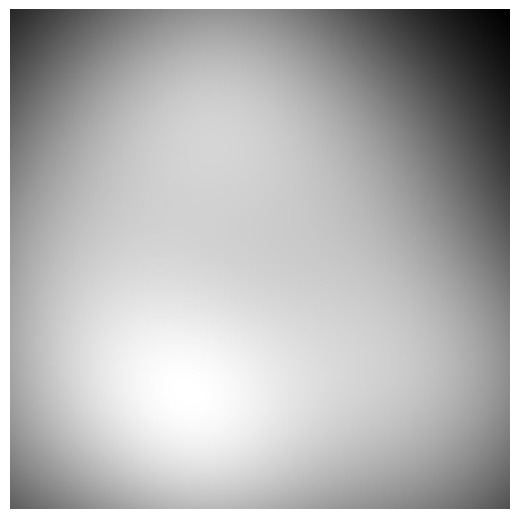

In [ ]:
#| export

if __name__ == "__main__":
    project_imgs()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()